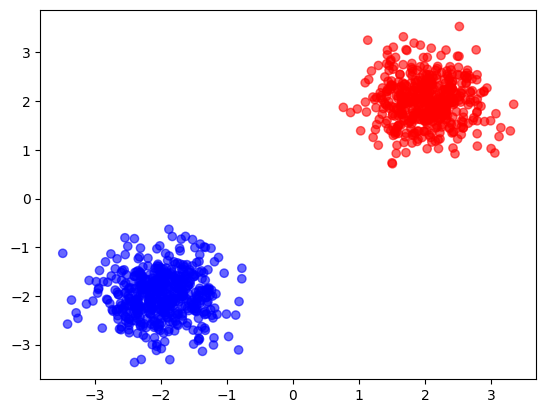

In [10]:
import itertools as it
import numpy as np
import matplotlib.pyplot as plt

class Distribution:
    def sample(self):
        raise NotImplementedError

class GaussianMixture(Distribution):
    def __init__(self, mu, sigma, class_, p, n, seed=None):
        if not (len(mu) == len(sigma) == len(class_) == len(p)):
            raise ValueError("All input lists must have the same length.")
        if sum(p) != 1:
            raise ValueError("Probabilities p must sum to 1.")
        
        self.mu = mu
        self.sigma = sigma
        self.class_ = class_
        self.p = p
        self.n = n
        self.rng = np.random.default_rng(seed)

    def sample(self):
        for t in range(self.n):
            i = self.rng.choice(len(self.p), p=self.p)
            mu = self.mu[i]
            sigma = self.sigma[i]
            class_ = self.class_[i]
            x = self.rng.multivariate_normal(mu, np.diag(sigma))
            yield {f'x_{i}': x[i] for i in range(len(x))}, class_

d = GaussianMixture(mu=[[-2, -2], [2, 2]], sigma=[[0.2, 0.2], [0.2, 0.2]],
                    class_=[0, 1], p=[0.5, 0.5], n=1_000)

x_1 = []
x_2 = []
c = []
for x, y in it.islice(d.sample(), 10_000):
    x_1.append(x['x_0'])
    x_2.append(x['x_1'])
    c.append(y)

fig, ax = plt.subplots()
ax.scatter(x_1, x_2, c=c, cmap='bwr', alpha=0.6)
plt.show()

In [2]:
from sklearn.svm import OneClassSVM

X_train = np.array([[x["x_0"], x["x_1"]] for x, y in it.islice(d.sample(), 250)])
occ = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.1).fit(X_train)

n = 10_000
outlier = occ.predict(np.array([[x["x_0"], x["x_1"]] for x, y in it.islice(d.sample(), 10_000)]))
outlier_rate = (outlier==-1).mean()


print(f'empirical outlier fraction: {outlier_rate}')

empirical outlier fraction: 0.124


In [3]:
import numpy as np

class DriftingMixtureStream:
    def __init__(self, mixtures, drift_points):
        """
        mixtures: list of GaussianMixture instances (length >= 2)
        drift_points: list of ints or (start, end) tuples, length == len(mixtures) - 1

        Each drift_point defines when to move from mixture[i] to mixture[i+1]:
          - int: abrupt drift at that index
          - (start, end): gradual drift over that interval
        """
        if len(mixtures) < 2:
            raise ValueError("Need at least two mixtures to simulate drift.")
        if len(drift_points) != len(mixtures) - 1:
            raise ValueError("drift_points must have length len(mixtures) - 1.")
        
        self.mixtures = mixtures
        self.drift_points = drift_points
        self.t = 0
        self.current_idx = 0

    def _interpolate_mixtures(self, mix_a, mix_b, alpha):
        """Return a new GaussianMixture with parameters interpolated between A and B."""
        mu = [(1 - alpha) * np.array(ma) + alpha * np.array(mb)
              for ma, mb in zip(mix_a.mu, mix_b.mu)]
        sigma = [(1 - alpha) * np.array(sa) + alpha * np.array(sb)
                 for sa, sb in zip(mix_a.sigma, mix_b.sigma)]
        p = [(1 - alpha) * pa + alpha * pb for pa, pb in zip(mix_a.p, mix_b.p)]
        # normalize p to sum to 1 (to prevent rounding drift)
        total_p = sum(p)
        p = [pi / total_p for pi in p]
        class_ = mix_a.class_  # assume same class labels
        return GaussianMixture(mu, sigma, class_, p, n=1_000_000)

    def sample(self):
        while True:
            if self.current_idx >= len(self.mixtures) - 1:
                # Past last mixture
                yield next(self.mixtures[-1].sample())
                self.t += 1
                continue

            drift = self.drift_points[self.current_idx]

            if isinstance(drift, int):
                # Abrupt drift
                if self.t < drift:
                    yield next(self.mixtures[self.current_idx].sample())
                else:
                    self.current_idx += 1
                    yield next(self.mixtures[self.current_idx].sample())

            else:
                # Gradual drift: (start, end)
                start, end = drift
                if self.t < start:
                    yield next(self.mixtures[self.current_idx].sample())
                elif self.t > end:
                    self.current_idx += 1
                    yield next(self.mixtures[self.current_idx].sample())
                else:
                    alpha = (self.t - start) / (end - start)
                    interpolated_mix = self._interpolate_mixtures(
                        self.mixtures[self.current_idx],
                        self.mixtures[self.current_idx + 1],
                        alpha
                    )
                    yield next(interpolated_mix.sample())

            self.t += 1


In [ ]:

def to_dict(x_array):
    return {f'x_{i}': x_array[i] for i in range(len(x_array))}

def to_array(x_dict):
    return np.array([x_dict[f'x_{i}'] for i in range(len(x_dict))])

def learn_many(model, x_window, y_window):
    for x, y in zip(x_window, y_window):
        x_dict = to_dict(x)
        model.learn_one(x_dict, y)

def accumulate_examples(stream, n, x_window, y_window):
    for x, y in it.islice(stream.sample(), n):
        x_window.append(to_array(x))
        y_window.append(y)

import itertools as it

def accumulate_examples(stream, n, x_window, y_window, keep_fraction=0.0):
    """
    Refill sliding windows from a stream.

    Parameters
    ----------
    stream : iterable
        The data stream yielding (x, y) pairs.
    n : int
        Target window size (number of elements to gather).
    x_window, y_window : deque
        Existing deques for features and labels.
    keep_fraction : float, optional (default=0.0)
        Fraction of the most recent elements to keep before refilling.
        Must be between 0.0 and 1.0.
    """
    # Safety check
    if not (0.0 <= keep_fraction <= 1.0):
        raise ValueError("keep_fraction must be between 0.0 and 1.0")

    # Determine how many elements to retain
    m = int(len(x_window) * keep_fraction)

    # Keep the last m elements
    if m > 0:
        x_recent = list(it.islice(x_window, len(x_window) - m, None))
        y_recent = list(it.islice(y_window, len(y_window) - m, None))
    else:
        x_recent, y_recent = [], []

    # Clear and reinitialize with the recent ones
    x_window.clear()
    y_window.clear()
    x_window.extend(x_recent)
    y_window.extend(y_recent)

    # Fill up the rest from the stream
    n_new = n - len(x_window)
    for x, y in it.islice(stream.sample(), n_new):
        x_window.append(to_array(x))
        y_window.append(y)


def window_accuracy(model, x_window, y_window):
    a = 0
    for x, y in zip(x_window, y_window):
        y_hat = model.predict_one(to_dict(x))
        a += (y_hat == y)
    return a / len(x_window)

In [ ]:
import math
import scipy.stats as st

class DriftDetector:
    def detect(self):
        raise NotImplementedError
    
class ThresholdDriftDetector(DriftDetector):
    def __init__(self, f):
        self.f = f

    def detect(self, outliers):
        outlier_fraction = np.mean(outliers)
        return outlier_fraction > self.f

class ZTestDriftDetector(DriftDetector):
    def __init__(self, alpha, outliers):
        self.alpha = alpha
        self.outliers_orig = outliers
        self.tot_orig = sum(outliers)
        self.n_orig = len(outliers)

    def detect(self, outliers):
        tot = sum(outliers)
        n = len(outliers)
        p_outliers = tot / n
        p_orig = self.tot_orig / self.n_orig
        # print(f'p_orig: {p_orig}, p_outliers: {p_outliers}')

        z = st.norm()
        c = abs(p_outliers - p_orig)
        # print(f'Z-Test statistic: {math.sqrt(2*n) * c}, Threshold: {z.ppf(1 - self.alpha / 2)}')
        return c > z.ppf(1 - self.alpha / 2) / math.sqrt(2*n)


Drift detected at t=4212, with accuracy 0.96
After accumulation, t=4437
Post-drift accuracy: 0.964
Drift detected at t=4597, with accuracy 1.0
After accumulation, t=4822
Post-drift accuracy: 0.996
Drift detected at t=5281, with accuracy 1.0
After accumulation, t=5506
Post-drift accuracy: 1.0
deque([array([0.19444294, 0.05886642]), array([2.99924742, 2.80206763]), array([2.90919007, 2.33074162]), array([2.22778817, 3.27636492]), array([3.13420244, 3.06107798]), array([3.19606077, 3.07079549]), array([-0.14472961,  0.1901119 ]), array([3.75420677, 2.39038056]), array([2.29961216, 3.67971327]), array([0.15678767, 0.07427988]), array([3.5417211 , 3.51789333]), array([2.84382036, 3.34306865]), array([2.91474433, 2.84291671]), array([3.74421535, 2.66486002]), array([0.15694204, 0.21761369]), array([0.84233603, 0.18876674]), array([ 0.78659687, -0.20082646]), array([2.43949726, 2.92292253]), array([0.3344484 , 0.18782826]), array([-0.04491085,  0.34053813]), array([0.09130665, 0.3128303 ]), a

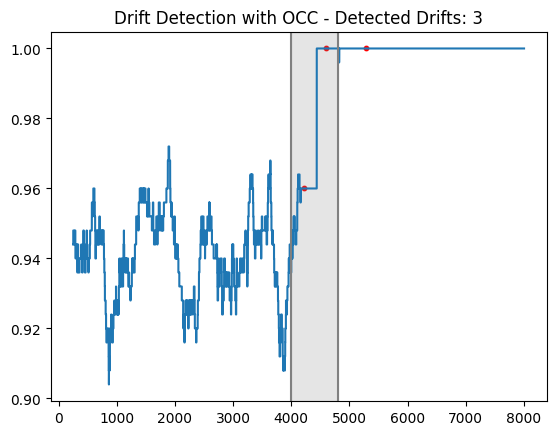

In [ ]:
from collections import deque
import itertools as it
from river import stream, tree, metrics

keep_fraction = 0.1
def experiment(n, f, nu, gamma, max_t, stream):

    x_window = deque(maxlen=n)
    y_window = deque(maxlen=n)
    outlier_window = deque(maxlen=n)
    detected_drifts = []
    accuracy = []

    accumulate_examples(stream, n, x_window, y_window)
    t = n

    model = tree.HoeffdingTreeClassifier()
    learn_many(model, np.array(x_window), np.array(y_window))
    accuracy.append((n, window_accuracy(model, x_window, y_window)))


    occ = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)
    occ.fit(np.array(x_window))
    for x in x_window:
        curr_x = np.array([x[i] for i in range(len(x))])
        outlier = occ.predict(np.array([curr_x]))[0]
        outlier_window.append(outlier==-1)
    d = ZTestDriftDetector(0.025, outlier_window)

    for x, y in it.islice(stream.sample(), max_t - n):
        t += 1
        y_pred = model.predict_one(x)

        # keep sliding window
        curr_x = to_array(x)

        x_window.append(curr_x)
        y_window.append(y)

        #check for drift using OCC
        outlier = occ.predict(np.array([curr_x]))[0]
        outlier_window.append(outlier==-1)

        # d = ThresholdDriftDetector(f)
        
        if d.detect(outlier_window):
            print(f'Drift detected at t={t}, with accuracy {accuracy[-1][1]}')
            accumulate_examples(stream, n, x_window, y_window,
                                keep_fraction=keep_fraction)
            
            detected_drifts.append((t, accuracy[-1][1]))
            t += int(n * (1 - keep_fraction))
            print(f'After accumulation, t={t}')
            a = window_accuracy(model, x_window, y_window)
            print(f'Post-drift accuracy: {a}')
            accuracy.append((t, a))
            
            # retrain model on current window
            model = tree.HoeffdingTreeClassifier()
            learn_many(model, np.array(x_window), np.array(y_window))
            # retrain OCC on current window
            occ.fit(np.array(x_window))

            # populate outlier window
            outlier_window.clear()
            for x in x_window:
                curr_x = np.array([x[i] for i in range(len(x))])
                outlier = occ.predict(np.array([curr_x]))[0]
                outlier_window.append(outlier==-1)
        else:
            accuracy.append((t, window_accuracy(model, x_window, y_window)))

        if t > max_t:
            break

    # print(x_window)
    return accuracy, detected_drifts

n = 250 # window size
f = 0.1 # outlier fraction threshold
nu = 0.1 # OCC parameter
gamma = 0.5 # OCC parameter
max_t = 8_000 # max number of examples to process

g1 = GaussianMixture(mu=[[0, 0], [1, 1]], sigma=[[0.2, 0.2], [0.2, 0.2]],
                     class_=[0, 1], p=[0.5, 0.5], n=80_000, seed=42)
g2 = GaussianMixture(mu=[[0, 0], [3, 3]], sigma=[[0.2, 0.2], [0.2, 0.2]],
                     class_=[0, 1], p=[0.5, 0.5], n=80_000, seed=42)

start_drift, end_drift = 4_000, 4_800
stream = DriftingMixtureStream(mixtures=[g1, g2],
                               drift_points=[(start_drift, end_drift)])

accuracy, detected_drifts = experiment(n, f, nu, gamma, max_t, stream)
        
num_drifts =len(detected_drifts)

fix, ax = plt.subplots()
u, v = zip(*accuracy)
ax.step(u, v, where='post')
if detected_drifts:
    u, v = zip(*detected_drifts)
    ax.scatter(u, v, color='red', label='Detected Drifts', s=10)
ax.axvspan(start_drift, end_drift, color='gray', alpha=0.2)
ax.axvline(start_drift, color='gray', linewidth=1.5, alpha=1.0)
ax.axvline(end_drift, color='gray', linewidth=1.5, alpha=1.0)
ax.set_title(f'Drift Detection with OCC - Detected Drifts: {num_drifts}')
plt.show()

In [64]:
detected_drifts

[(4252, np.float64(0.964)), (4643, np.float64(1.0))]

deque([array([2.92532725, 2.41253887]), array([3.95188653, 2.36315963]), array([ 0.74162156, -0.34765224]), array([0.17553343, 0.29437997]), array([-0.8004447 ,  0.08536355]), array([-0.01778691,  0.02014136]), array([2.51375014, 2.54421097]), array([-0.61785798,  0.54857152]), array([3.04265684, 3.88019637]), array([-0.64314457, -0.15072292]), array([0.46088491, 0.02113528]), array([0.76919392, 0.70674762]), array([2.71999314, 1.81431898]), array([-0.69041092, -0.02736317]), array([3.88361359, 3.56957561]), array([0.11357533, 0.17992258]), array([-0.39070057, -0.1926336 ]), array([ 0.17282762, -0.5879041 ]), array([3.20071007, 2.88769136]), array([0.32735781, 0.62675971]), array([-0.13427248, -0.07381849]), array([ 0.47225403, -0.17392604]), array([0.21577831, 0.23671469]), array([3.82876268, 2.75750165]), array([-0.59882825,  0.1235982 ]), array([2.96732055, 3.34057148]), array([2.68788852, 2.90045699]), array([0.3348534 , 0.26290716]), array([3.06399671, 3.19447899]), array([3.41182

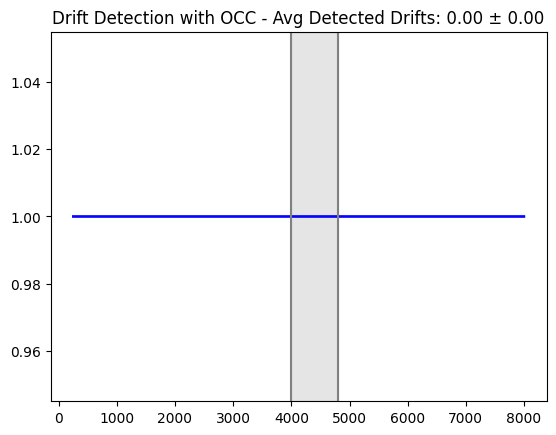

In [71]:
fix, ax = plt.subplots()

num_drifts = []
for seed in np.arange(42, 142, 10):
    g1 = GaussianMixture(mu=[[0, 0], [1, 1]], sigma=[[1, 1], [0.2, 0.2]],
                     class_=[0, 1], p=[0.5, 0.5], n=8_000, seed=seed)
    g2 = GaussianMixture(mu=[[0, 0], [3, 3]], sigma=[[1, 1], [0.3, 0.3]],
                        class_=[0, 1], p=[0.5, 0.5], n=8_000, seed=seed)

    accuracy, detected_drifts = experiment(n, f, nu, gamma, max_t, stream)
    num_drifts.append(len(detected_drifts))
    u, v = zip(*accuracy)
    ax.step(u, v, color='blue', alpha=0.3)
    if detected_drifts:
        u, v = zip(*detected_drifts)
        ax.scatter(u, v, color='red', label='Detected Drifts', s=10)

ax.axvspan(4_000, 4_800, color='gray', alpha=0.2)
ax.axvline(4_000, color='gray', linewidth=1.5, alpha=1.0)
ax.axvline(4_800, color='gray', linewidth=1.5, alpha=1.0)
ax.set_title(f'Drift Detection with OCC - Avg Detected Drifts: {np.mean(num_drifts):.2f} ± {np.std(num_drifts):.2f}')
# ax.set_ylim(0.95, 1.01)
plt.show()